<a href="https://colab.research.google.com/github/HedersonSantos/age-related/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.tensorflow.org/guide/core/logistic_regression_core

In [2]:
#!wget https://raw.githubusercontent.com/HedersonSantos/age-related/main/tree_features\ .csv
#!mv tree_features\ .csv tree_features.csv

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)



2.12.0


In [4]:
df = pd.read_csv('tree_features.csv', header=0)
#df['Class']=df['Class'].apply(lambda x: 'S' if x==1 else 'N')
#df['Class']=df['Class'].astype('category')
df.head(10)

,AB,AF,BC,BQ,CC,CR,DA,DE,DH,DI,DU,EE,EH,FD,FE,FI,FL,FR,GL,Class
0,0.209377,3109.03329,5.555634,152.707705,0.563481,0.069225,69.08340,295.570575,0.284232,89.245560,5.310690,1.987283,0.949104,10.265073,9028.291921,3.583450,7.298162,1.73855,0.120343,1
1,0.145282,978.76416,1.229900,14.754720,0.484710,1.117800,70.79836,178.553100,0.363489,110.581815,0.005518,0.858603,0.003042,0.296850,6785.003474,10.358927,0.173229,0.49706,21.978000,0
2,0.470030,2635.10654,1.229900,219.320160,0.495852,0.700350,70.81970,321.426625,0.210441,120.056438,1.289739,8.146651,0.377208,8.745201,8338.906181,11.626917,7.709560,0.97556,0.196941,0
3,0.252107,3819.65177,1.229900,11.050410,0.717882,0.636075,47.27586,196.607985,0.292431,139.824570,2.655345,3.813326,0.614484,7.884336,10965.766040,14.852022,6.122162,0.49706,0.155829,0
4,0.380297,3733.04844,102.151980,149.717165,0.536467,0.693150,74.06532,200.178160,0.207708,97.920120,1.144902,3.490846,0.164268,4.274640,16198.049590,13.666727,8.153058,48.50134,0.096614,1
5,0.209377,2615.81430,1.229900,16.526120,0.639460,0.857625,55.22404,135.489250,0.478275,135.317865,0.005518,2.394414,0.003042,0.296850,8517.278846,10.981896,0.173229,0.49706,21.978000,0
6,0.348249,1733.65412,1.229900,344.644105,0.946323,0.610950,19.21570,107.907985,0.460510,176.625563,1.006962,2.620150,0.097344,1.460502,3903.806766,10.777915,4.408484,0.86130,0.065096,0
7,0.269199,966.45483,1.229900,6.199900,0.771909,1.109625,63.21684,326.225295,0.325227,83.769368,2.117379,3.277203,0.292032,4.518057,18090.349450,10.342388,6.591896,0.49706,0.092873,0
8,0.346113,3238.43674,3.626448,61.642115,0.855496,1.050375,76.77356,231.134460,0.330693,131.349555,0.613833,1.342323,0.066924,1.389258,3380.026318,11.450501,4.762291,1.18262,0.073416,0
9,0.324748,5188.68207,1.229900,107.276505,0.718271,0.711712,31.17774,403.247940,0.351191,129.175267,0.005518,3.658132,0.003042,0.296850,3142.390734,12.329825,0.173229,1.57151,21.978000,0


In [5]:
train_dataset = df.sample(frac=0.85, random_state=1)
test_dataset = df.drop(train_dataset.index)

In [6]:
test_dataset.shape

(93, 20)

In [7]:
x_train, y_train = train_dataset.iloc[:,:-1], train_dataset.iloc[:, -1]
x_test, y_test = test_dataset.iloc[:, :-1], test_dataset.iloc[:, -1]

In [8]:
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [9]:
#sns.pairplot(df, diag_kind='kde');

In [10]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [11]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [28]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [14]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [15]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []
log_reg = LogisticRegression()

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 1.147
Epoch: 20, Training log loss: 0.704
Epoch: 40, Training log loss: 0.537
Epoch: 60, Training log loss: 0.400
Epoch: 80, Training log loss: 0.381
Epoch: 100, Training log loss: 0.321
Epoch: 120, Training log loss: 0.295
Epoch: 140, Training log loss: 0.295
Epoch: 160, Training log loss: 0.281
Epoch: 180, Training log loss: 0.275


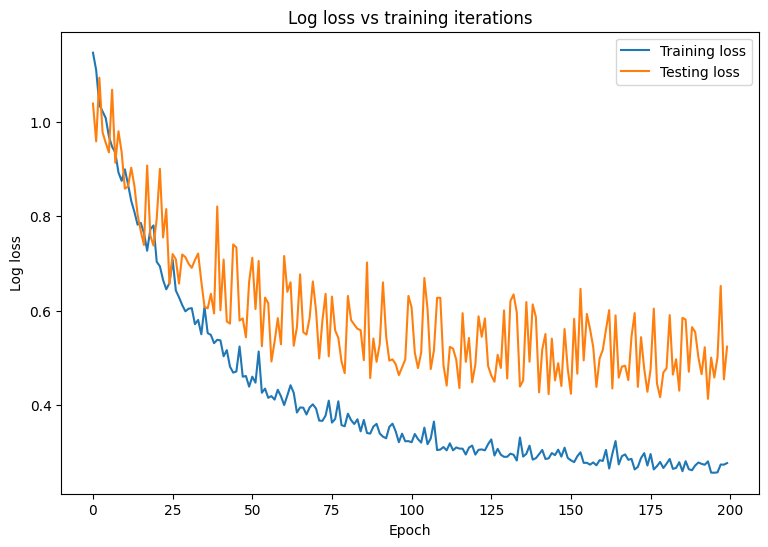

In [16]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

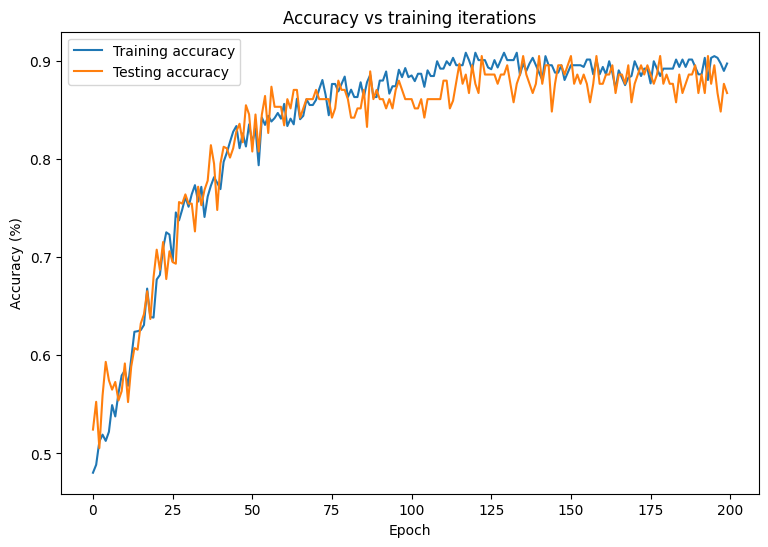

In [17]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [18]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.276
Final testing log Loss: 0.524


In [19]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.897
Final testing accuracy: 0.867


In [20]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

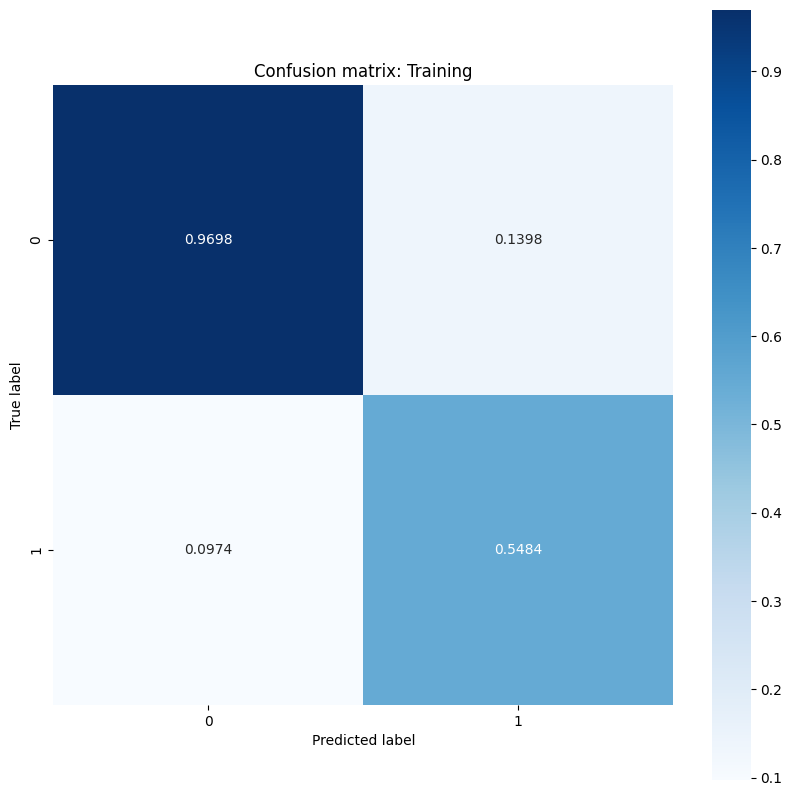

In [21]:
show_confusion_matrix(y_train, train_classes, 'Training')

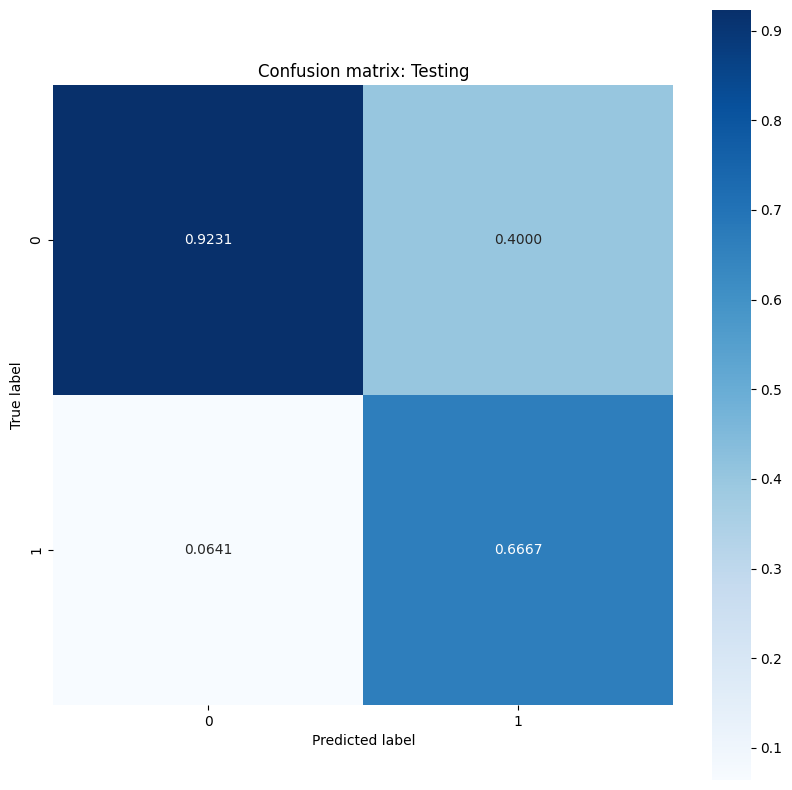

In [22]:
show_confusion_matrix(y_test, test_classes, 'Testing')

In [24]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [25]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

In [26]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

In [27]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)